In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input,Activation, BatchNormalization,Dropout
from tensorflow.keras.losses import *

from keras import Model
from kerastuner.tuners import Hyperband
from kerastuner import Objective
import numpy as np
import pandas as pd

# Build CNN hypermodel. 

We use filters of size [8,16,32,64,128]. Activation, filter size, dropout, optimization and loss are all selected at hyperparameter tuning time. We fix pooling size to a standard 2 and flatten down to 1 dimension at the end.

In [2]:
def create_cnn(hp):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    height,width,depth = 224,224,3
    filters=[8,16,32,64,128]
    inputShape = (height, width, depth)
    activation = hp.Choice('activation',values=['relu','sigmoid','softmax','softplus','softsign','tanh','selu','elu'])
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    filtersize = hp.Choice(f'filter', values=[2,3,4,5])
#     poolsize = hp.Choice(f'pool',values=[1,2,3])
    poolsize = 2
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (filtersize,filtersize), padding="same")(x)
        x = Activation(activation)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(poolsize,poolsize))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation(activation)(x)
    x = BatchNormalization(axis=chanDim)(x)
    dropout = hp.Choice('dropout',values=[0.0,0.25,0.5])
    x = Dropout(dropout)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation(activation)(x)
    # check to see if the regression node should be added
    x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    
    optimizer = hp.Choice('optimizer',values=['sgd','rmsprop','adam','adadelta','adagrad','adamax','nadam','ftrl'])
    loss = hp.Choice('loss',values=[
        'meansquarederror',
        'meanabsoluteerror',
        'meanabsolutepercentageerror',
        'meansquaredlogarithmicerror',
    ])
    # The reason this comes up twice is because we want to pass an actual _object_ to the autoencoder.compile function, but keras-tuner won't let us do this directly.
    loss = {
        'binarycrossentropy':BinaryCrossentropy,
        'categoricalcrossentropy':CategoricalCrossentropy,
        'poisson':Poisson,
        'kldivergence':KLDivergence,
        'meansquarederror':MeanSquaredError,
        'meanabsoluteerror':MeanAbsoluteError,
        'meanabsolutepercentageerror':MeanAbsolutePercentageError,
        'meansquaredlogarithmicerror':MeanSquaredLogarithmicError,
        'cosinesimilarity':CosineSimilarity,
        'huber':Huber,
        'logcosh':LogCosh,
        'hinge':Hinge,
        'squaredhinge':SquaredHinge,
        'categoricalhinge':CategoricalHinge
    }[loss]()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[MeanAbsolutePercentageError()]
    )
    
    return model

In [3]:
from pathlib import Path
train_data_dir = Path('./')
df = pd.read_pickle('labels.pickle')
predict = 'AVERAGE_HEIGHT' #This is what we are going to predict - easily changed.
df = df[df[predict] > 0]
df.height = df[predict].apply(np.log2) #Log transform to de-emphasize taller buildings.

batch_size = 8

# Hyperparameter tuning. 

First we obtain a subset of the data (1000 training samples, 100 validation samples).
Then, Hyperband searches over our hypermodel to select the best parameters for our problem.

In [4]:
train_datagen = ImageDataGenerator(rescale=None,
    validation_split=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = train_data_dir,
    x_col='filename',
    y_col='height',
    target_size = (224,224),
    batch_size = 1000,
    class_mode='raw',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = train_data_dir,
    x_col='filename',
    y_col='height',
    target_size = (224,224),
    batch_size = 100,
    class_mode='raw',
    color_mode='rgb',
    subset='validation'
)

Found 71449 validated image filenames.
Found 7938 validated image filenames.


In [5]:
tuner = Hyperband(
    create_cnn,
    objective=Objective("val_mean_absolute_percentage_error", direction="min"),
    max_epochs=100,
    directory='hyperband'
)

INFO:tensorflow:Reloading Oracle from existing project hyperband/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from hyperband/untitled_project/tuner0.json


In [6]:
X_train, y_train = train_generator.next()
X_test, y_test = validation_generator.next()

In [7]:
tuner.search(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    verbose=2
)

INFO:tensorflow:Oracle triggered exit


# Train real model

With the best hyperparameters identified, we now use all the data to train our optimal model.

In [8]:
model = create_cnn(tuner.get_best_hyperparameters()[0])

In [9]:
train_datagen = ImageDataGenerator(rescale=None,
#     shear_range=0.2,
#     zoom_range=0.2,
    validation_split=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = train_data_dir,
    x_col='filename',
    y_col='height',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode='raw',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = train_data_dir,
    x_col='filename',
    y_col='height',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode='raw',
    color_mode='rgb',
    subset='validation'
)

Found 71449 validated image filenames.
Found 7938 validated image filenames.


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

savepoint = Path('checkpoints/hyperband_singles')

es = EarlyStopping(monitor='val_loss', patience=10) #Stop training after 10 successive iterations of no improvement.
rl = ReduceLROnPlateau(monitor='val_loss', patience=5) #Reduce learning rate after 5 successive iterations of no improvement.
mc = ModelCheckpoint(savepoint.as_posix(),monitor='val_loss',save_best_only=True, save_weights_only=True) #Save best weights as we go.

if savepoint.exists():
    model.load(savepoint.as_posix())

model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 1000,
    verbose=2,
    callbacks=[es,rl,mc]
)

# Report real performance

First we show a histogram of true errors. Then, we show an example image and demonstrate what some of the filters are paying attention to.

In [55]:
from tqdm import tqdm

In [59]:
errors = []
for i,(imgs, labels) in enumerate(tqdm(validation_generator)):
    _, error = model.evaluate(imgs,labels,batch_size=1,verbose=0)
    error = (error/100)*labels
    for e in error:
        errors.append(e)
    if i>len(validation_generator):
        break

994it [00:35, 27.95it/s]                         


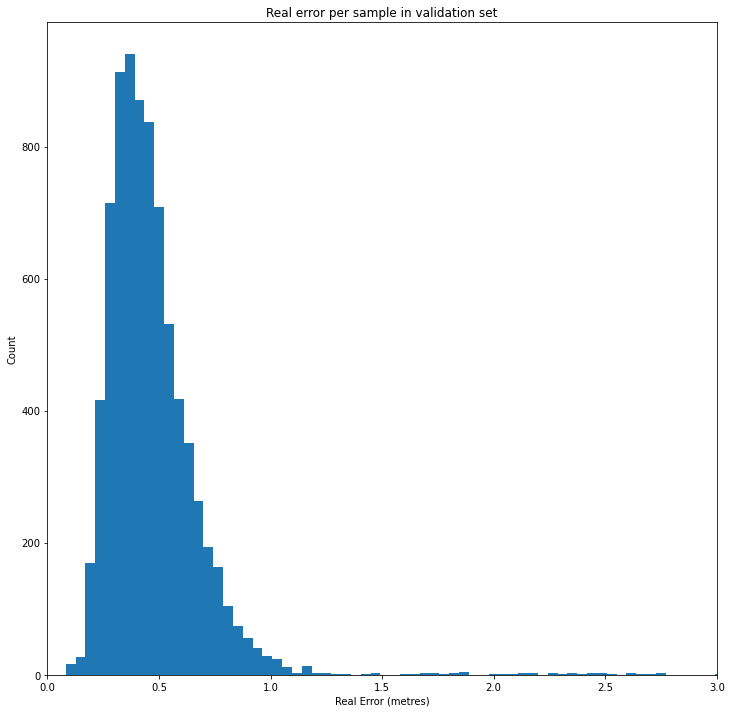

In [66]:
pyplot.figure(figsize=(12,12))
pyplot.hist(errors, bins=100)
pyplot.xlabel('Real Error (metres)')
pyplot.ylabel('Count')
pyplot.xlim([0,3])
pyplot.title('Real error per sample in validation set');

# Pick an image

We look for a well-performing image to run through the network for visualization. For example, image 4 here (index 3) gets an error of ~0.004, so we will look at that.

In [12]:
predictions = model.predict(imgs)

In [13]:
predictions.reshape((8)) - labels.reshape((8))

array([ 0.32229702, -0.23031555, -0.72105152,  0.00422993,  0.66065925,
       -1.83431617,  0.04383077, -0.98070471])

In [14]:
img = imgs[3,:,:,:].reshape((224,224,3))

In [15]:
label = labels[3]

8


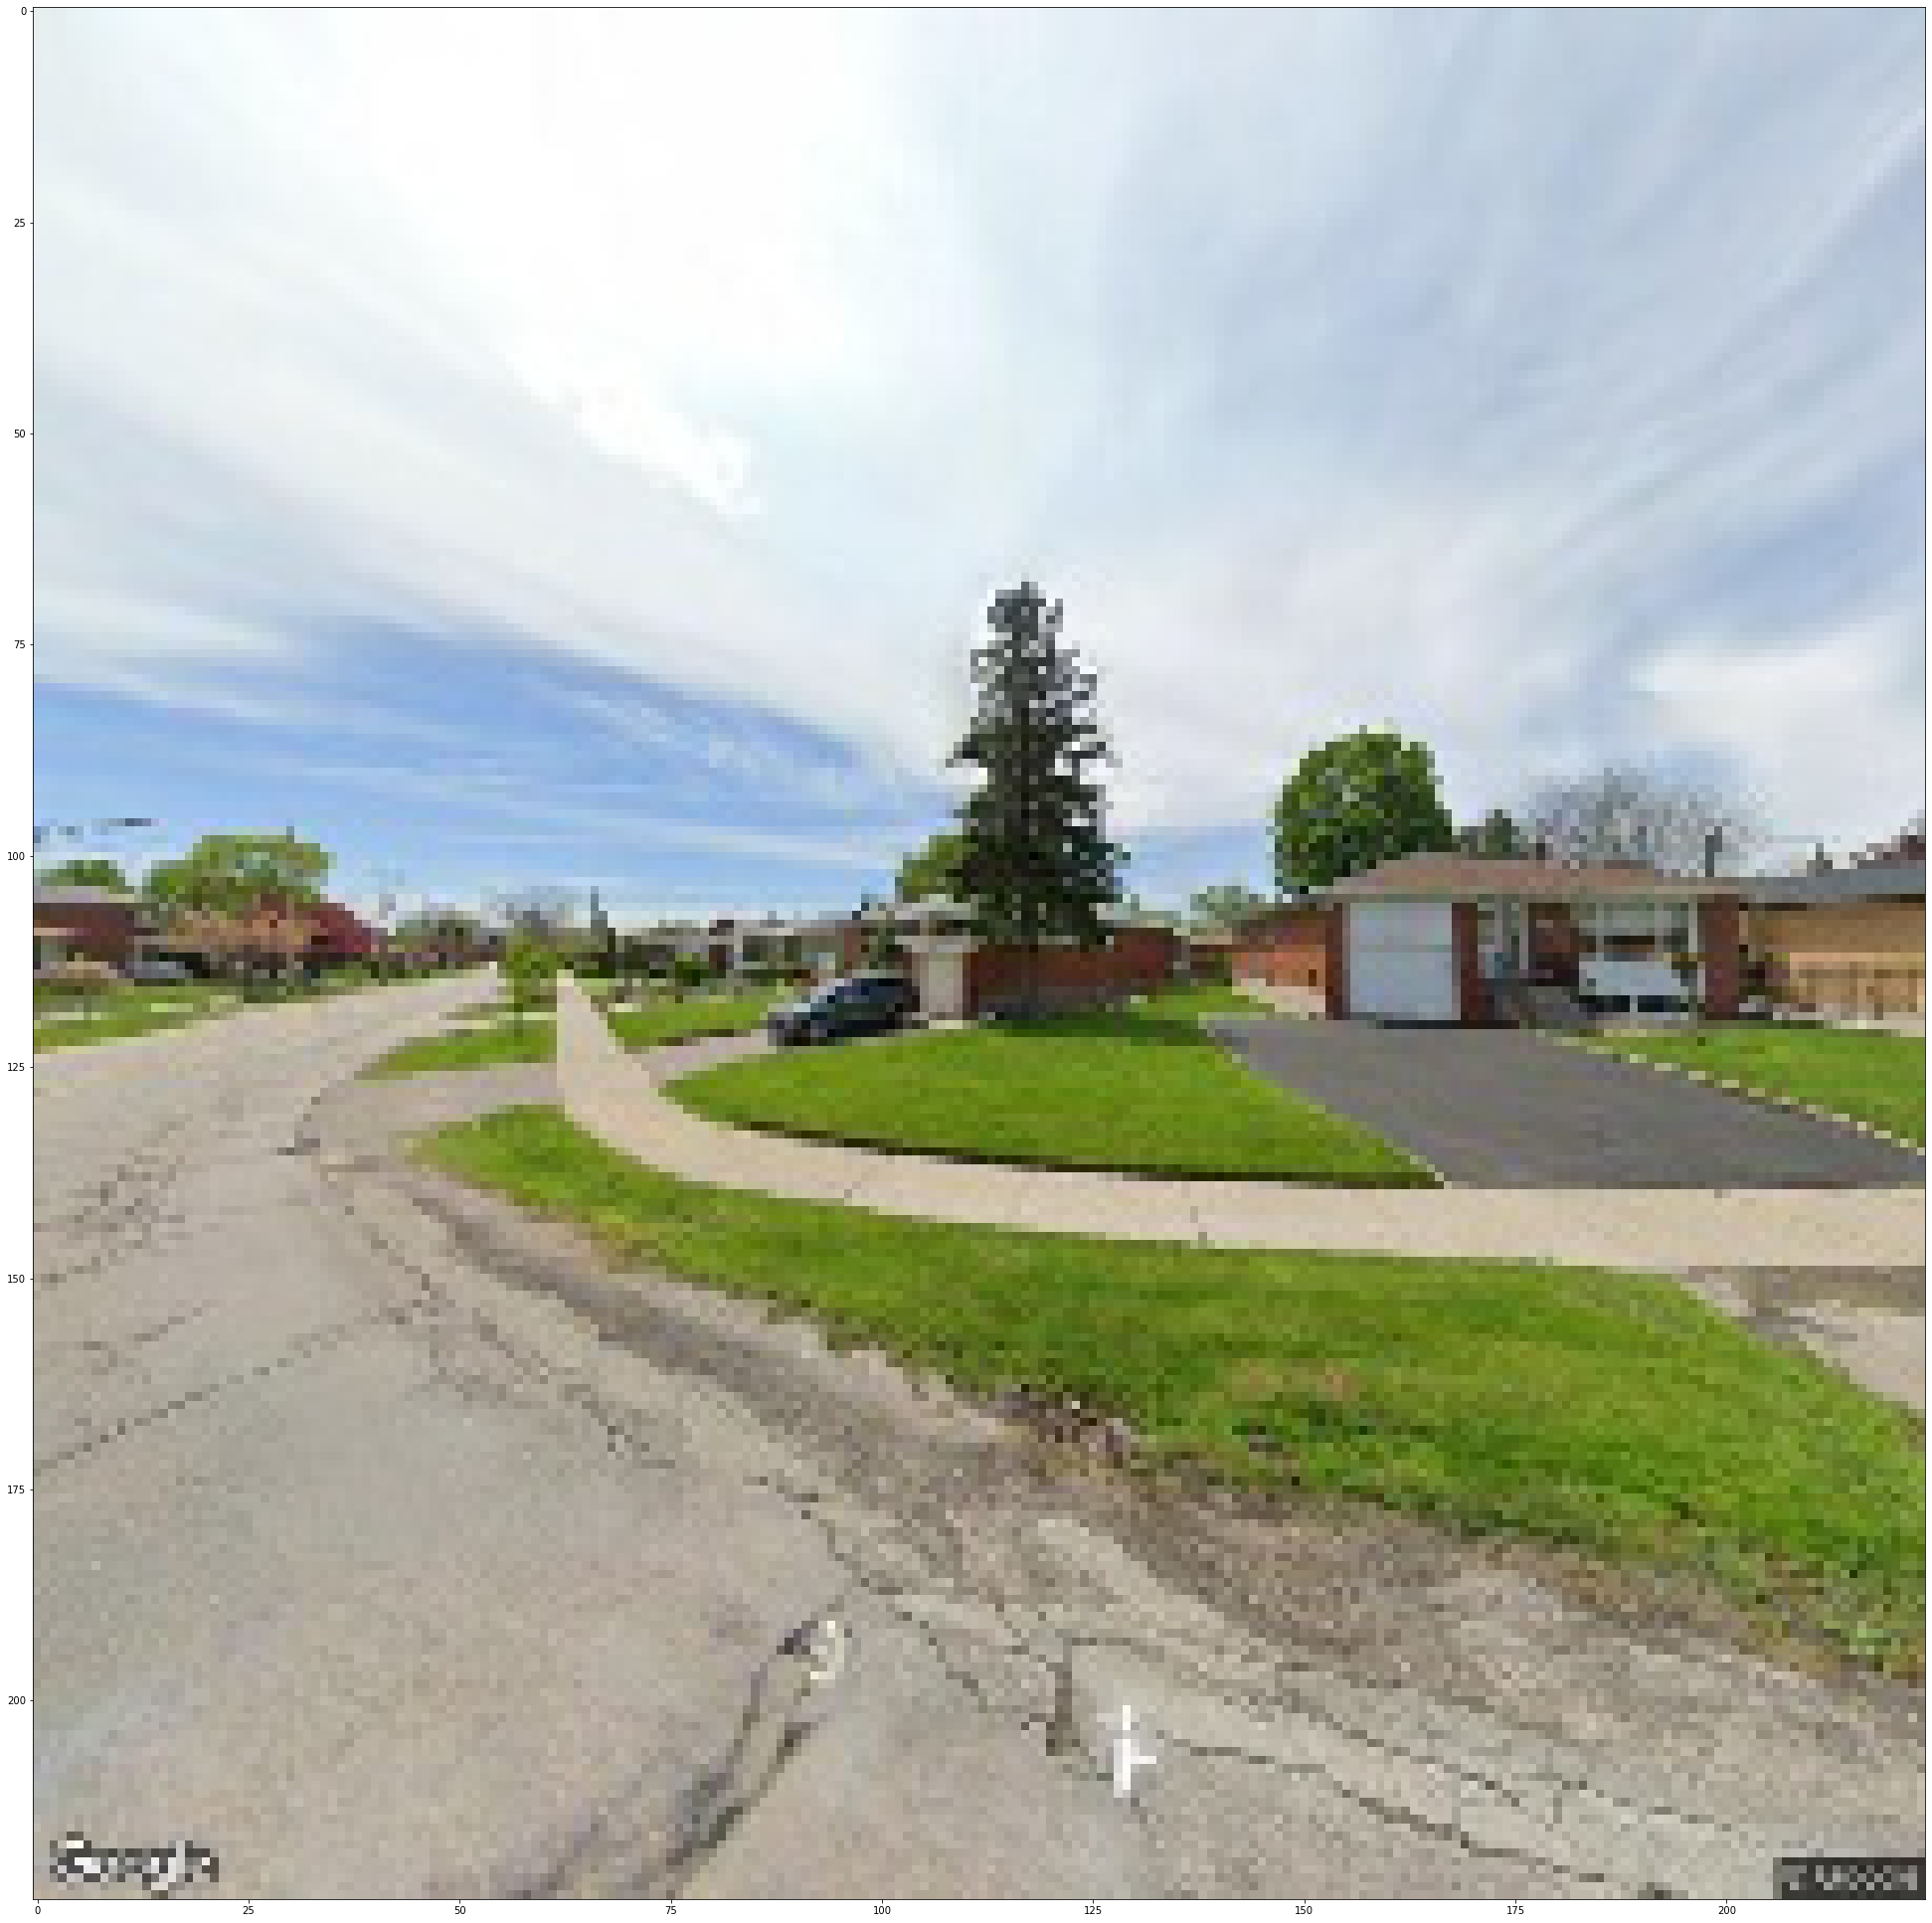

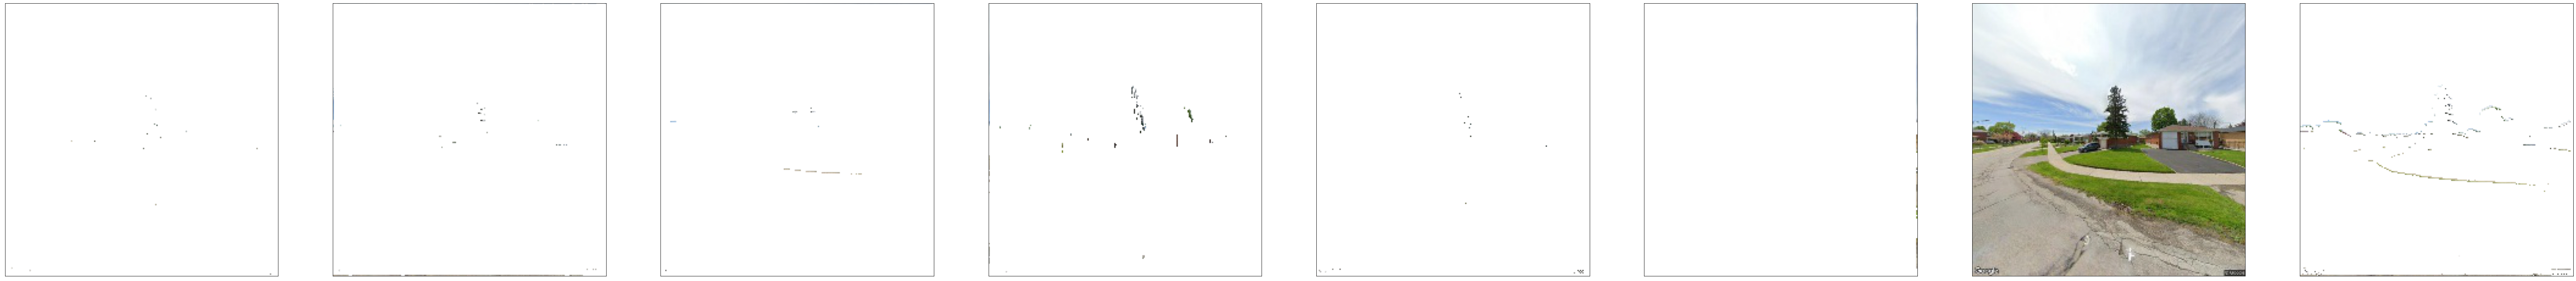

16


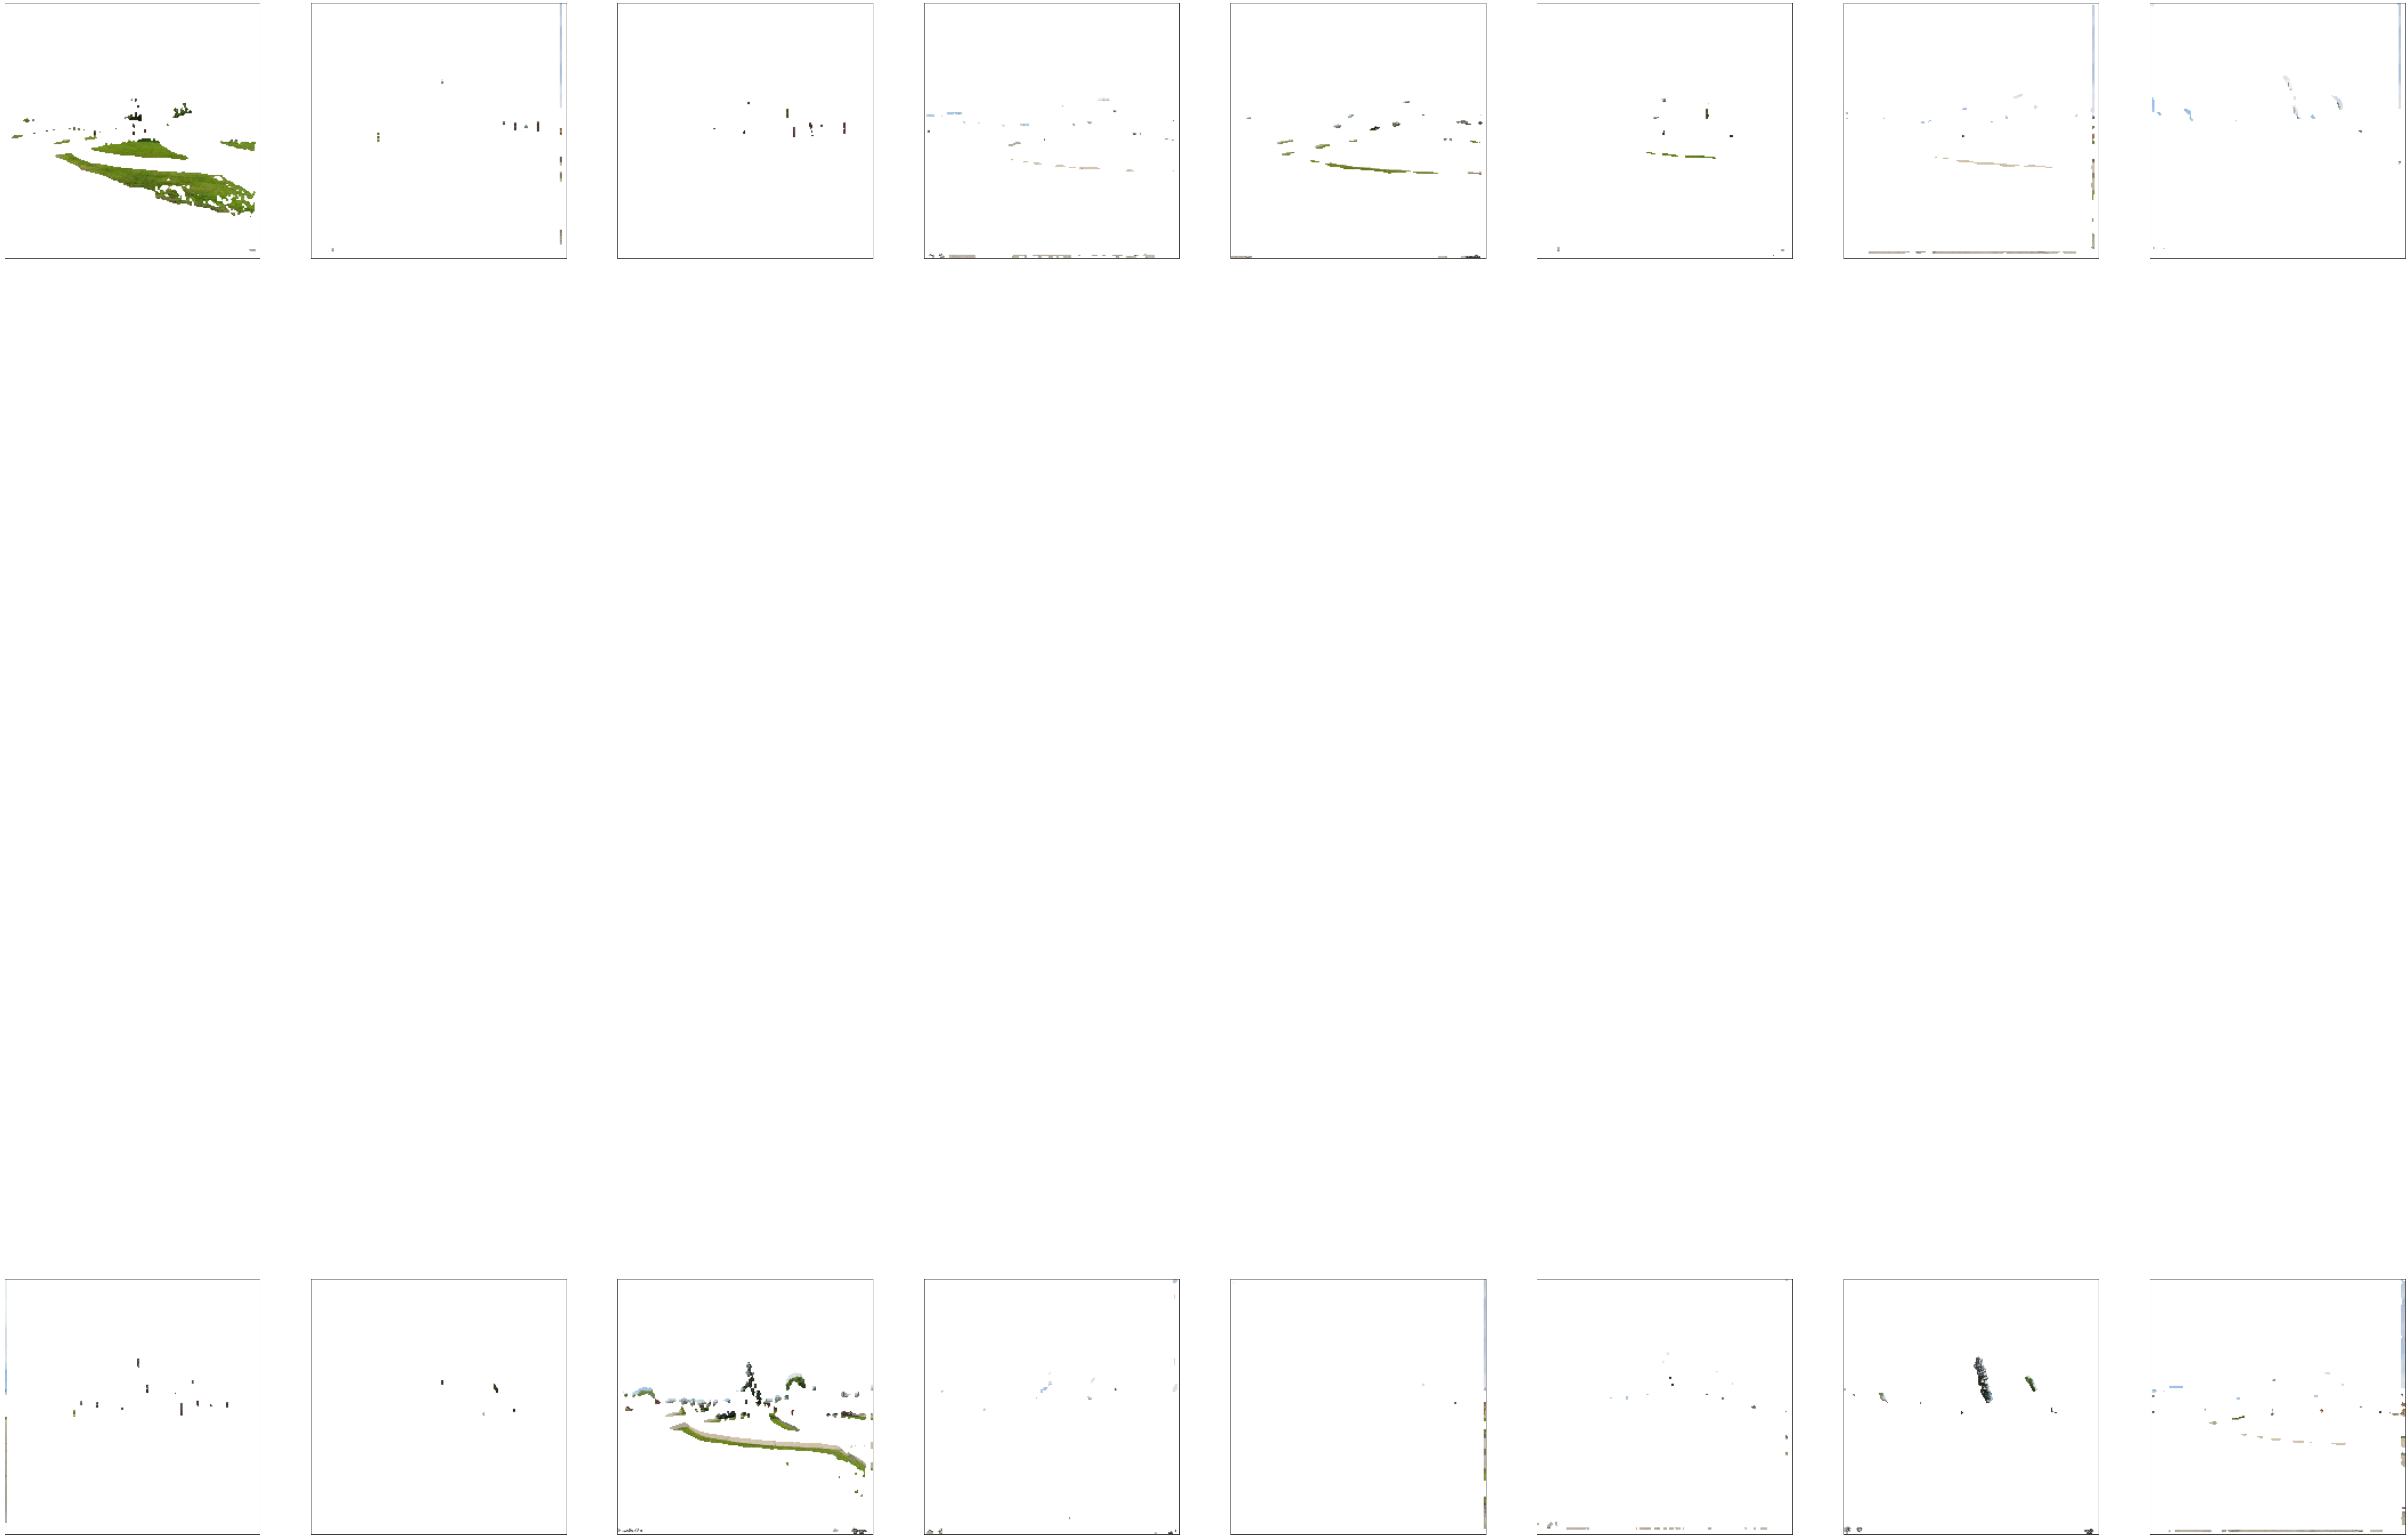

32


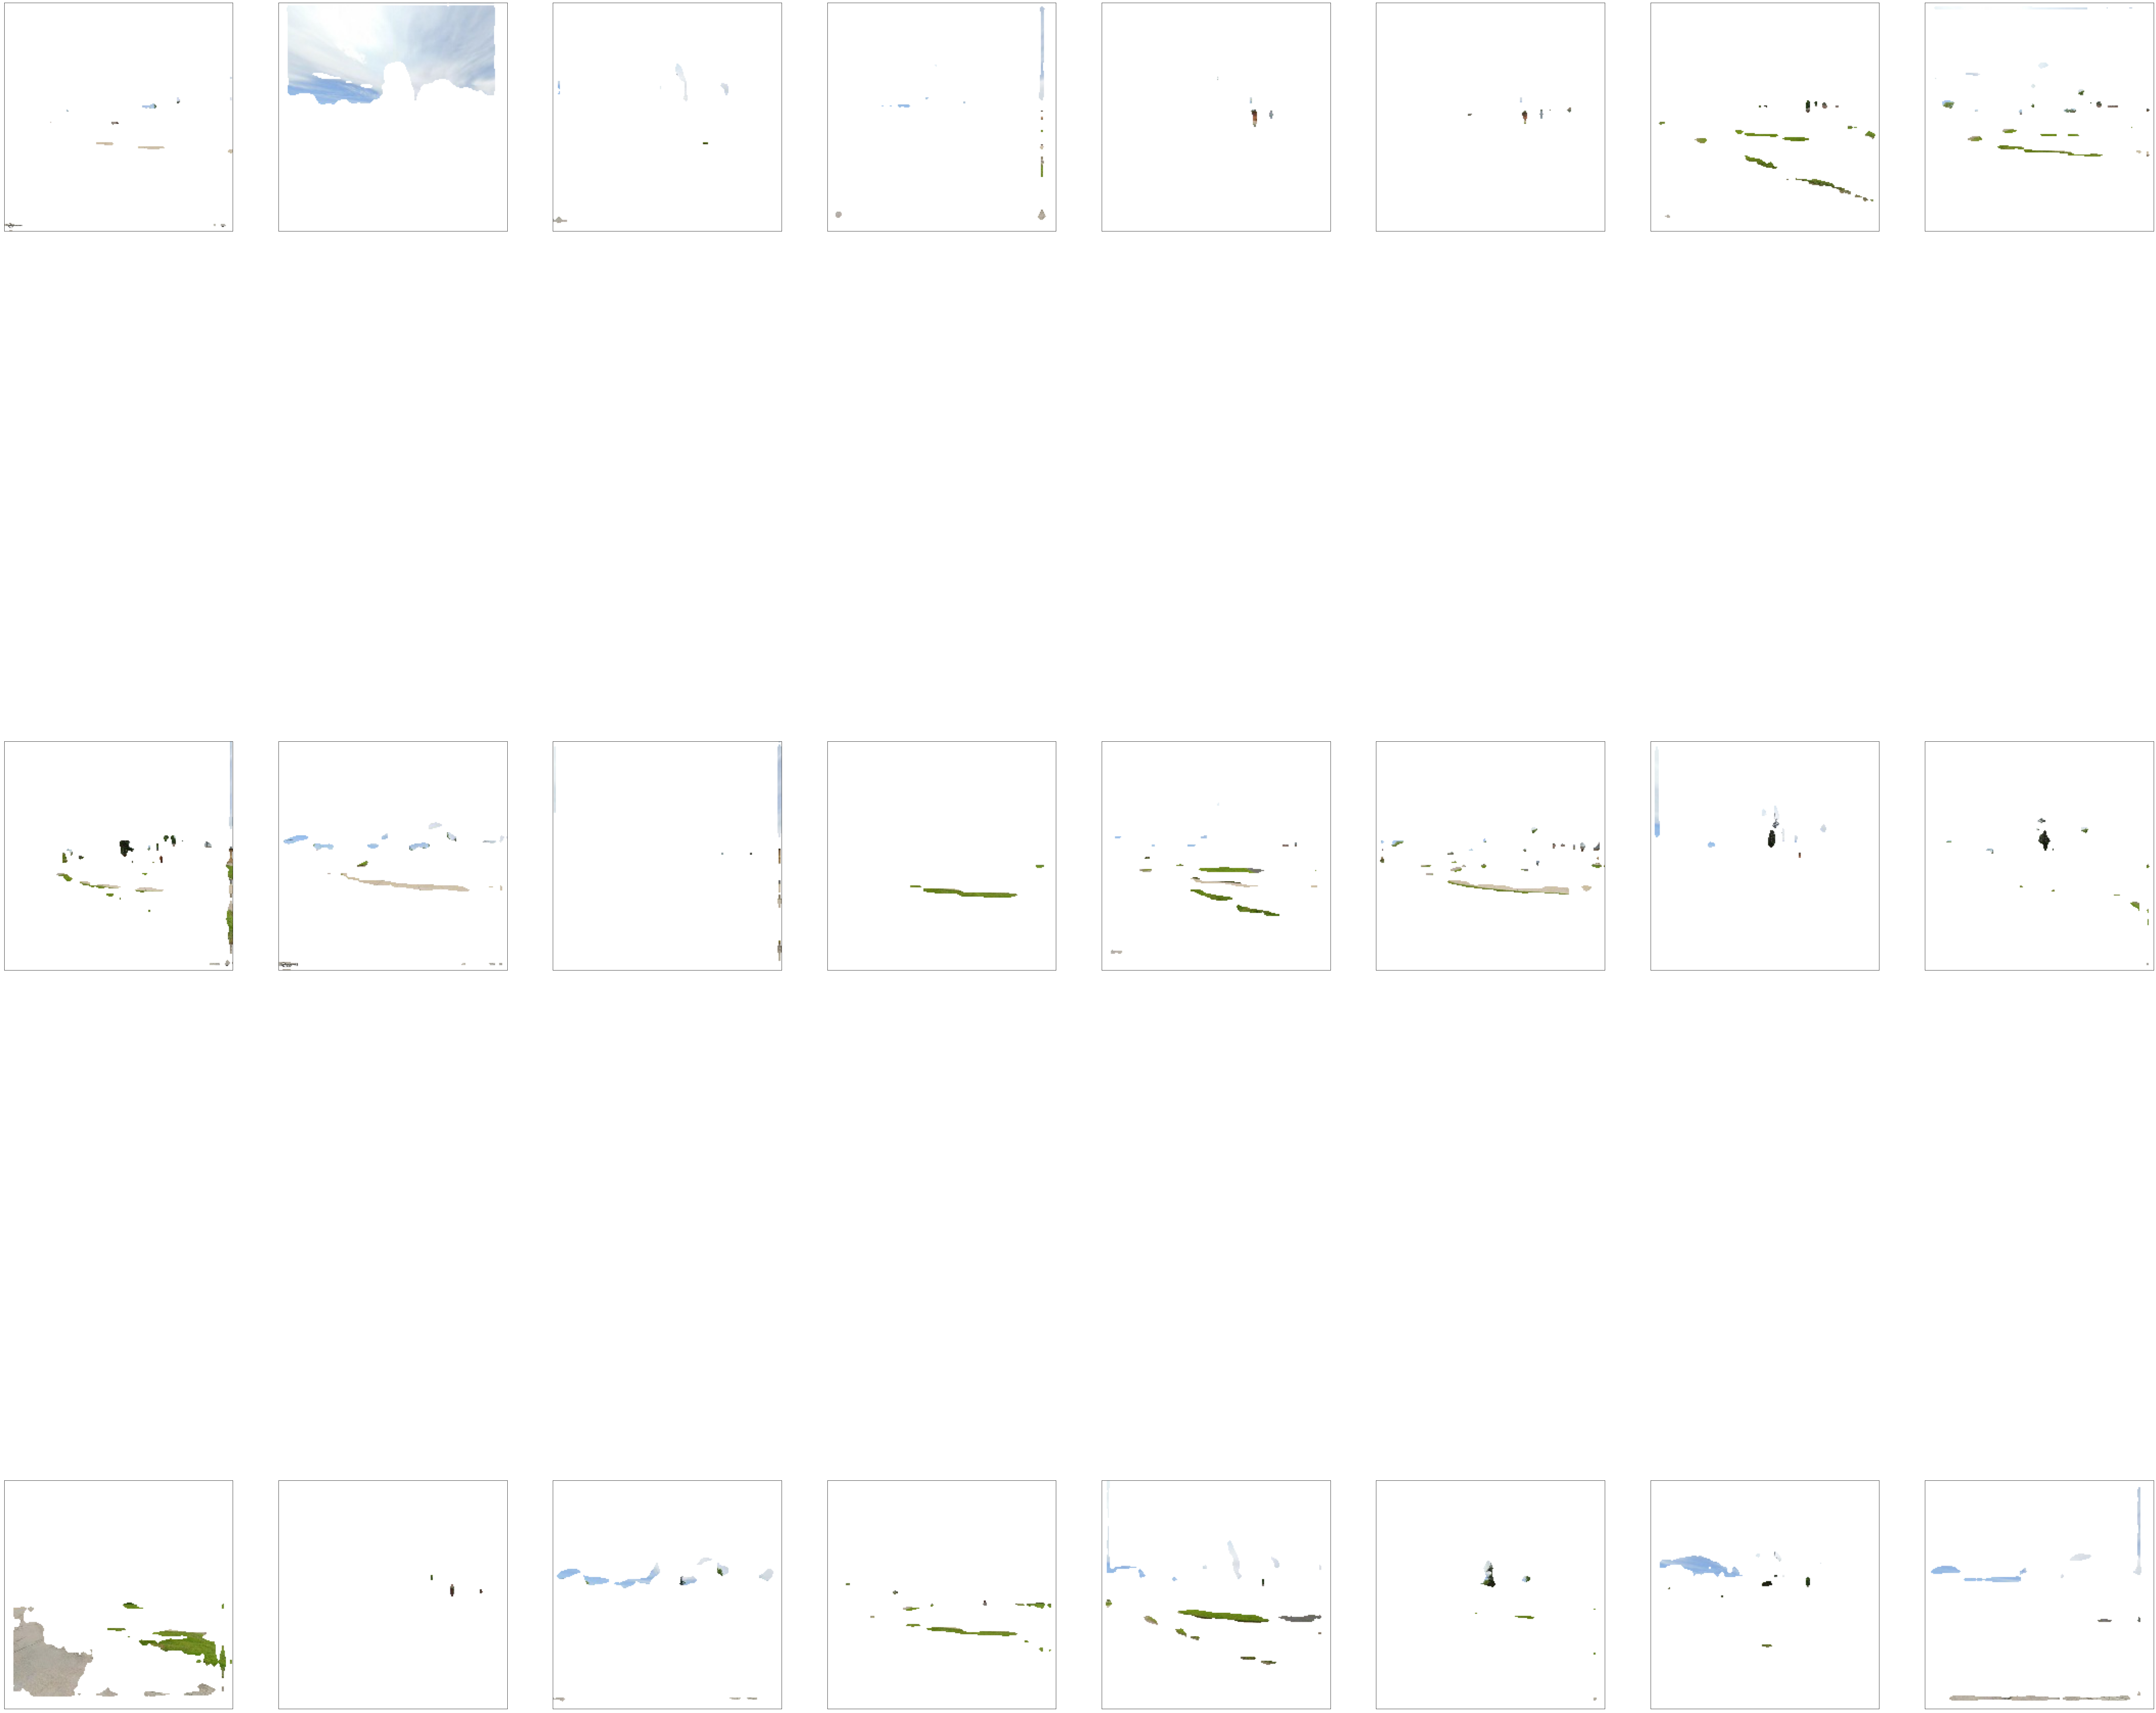

64


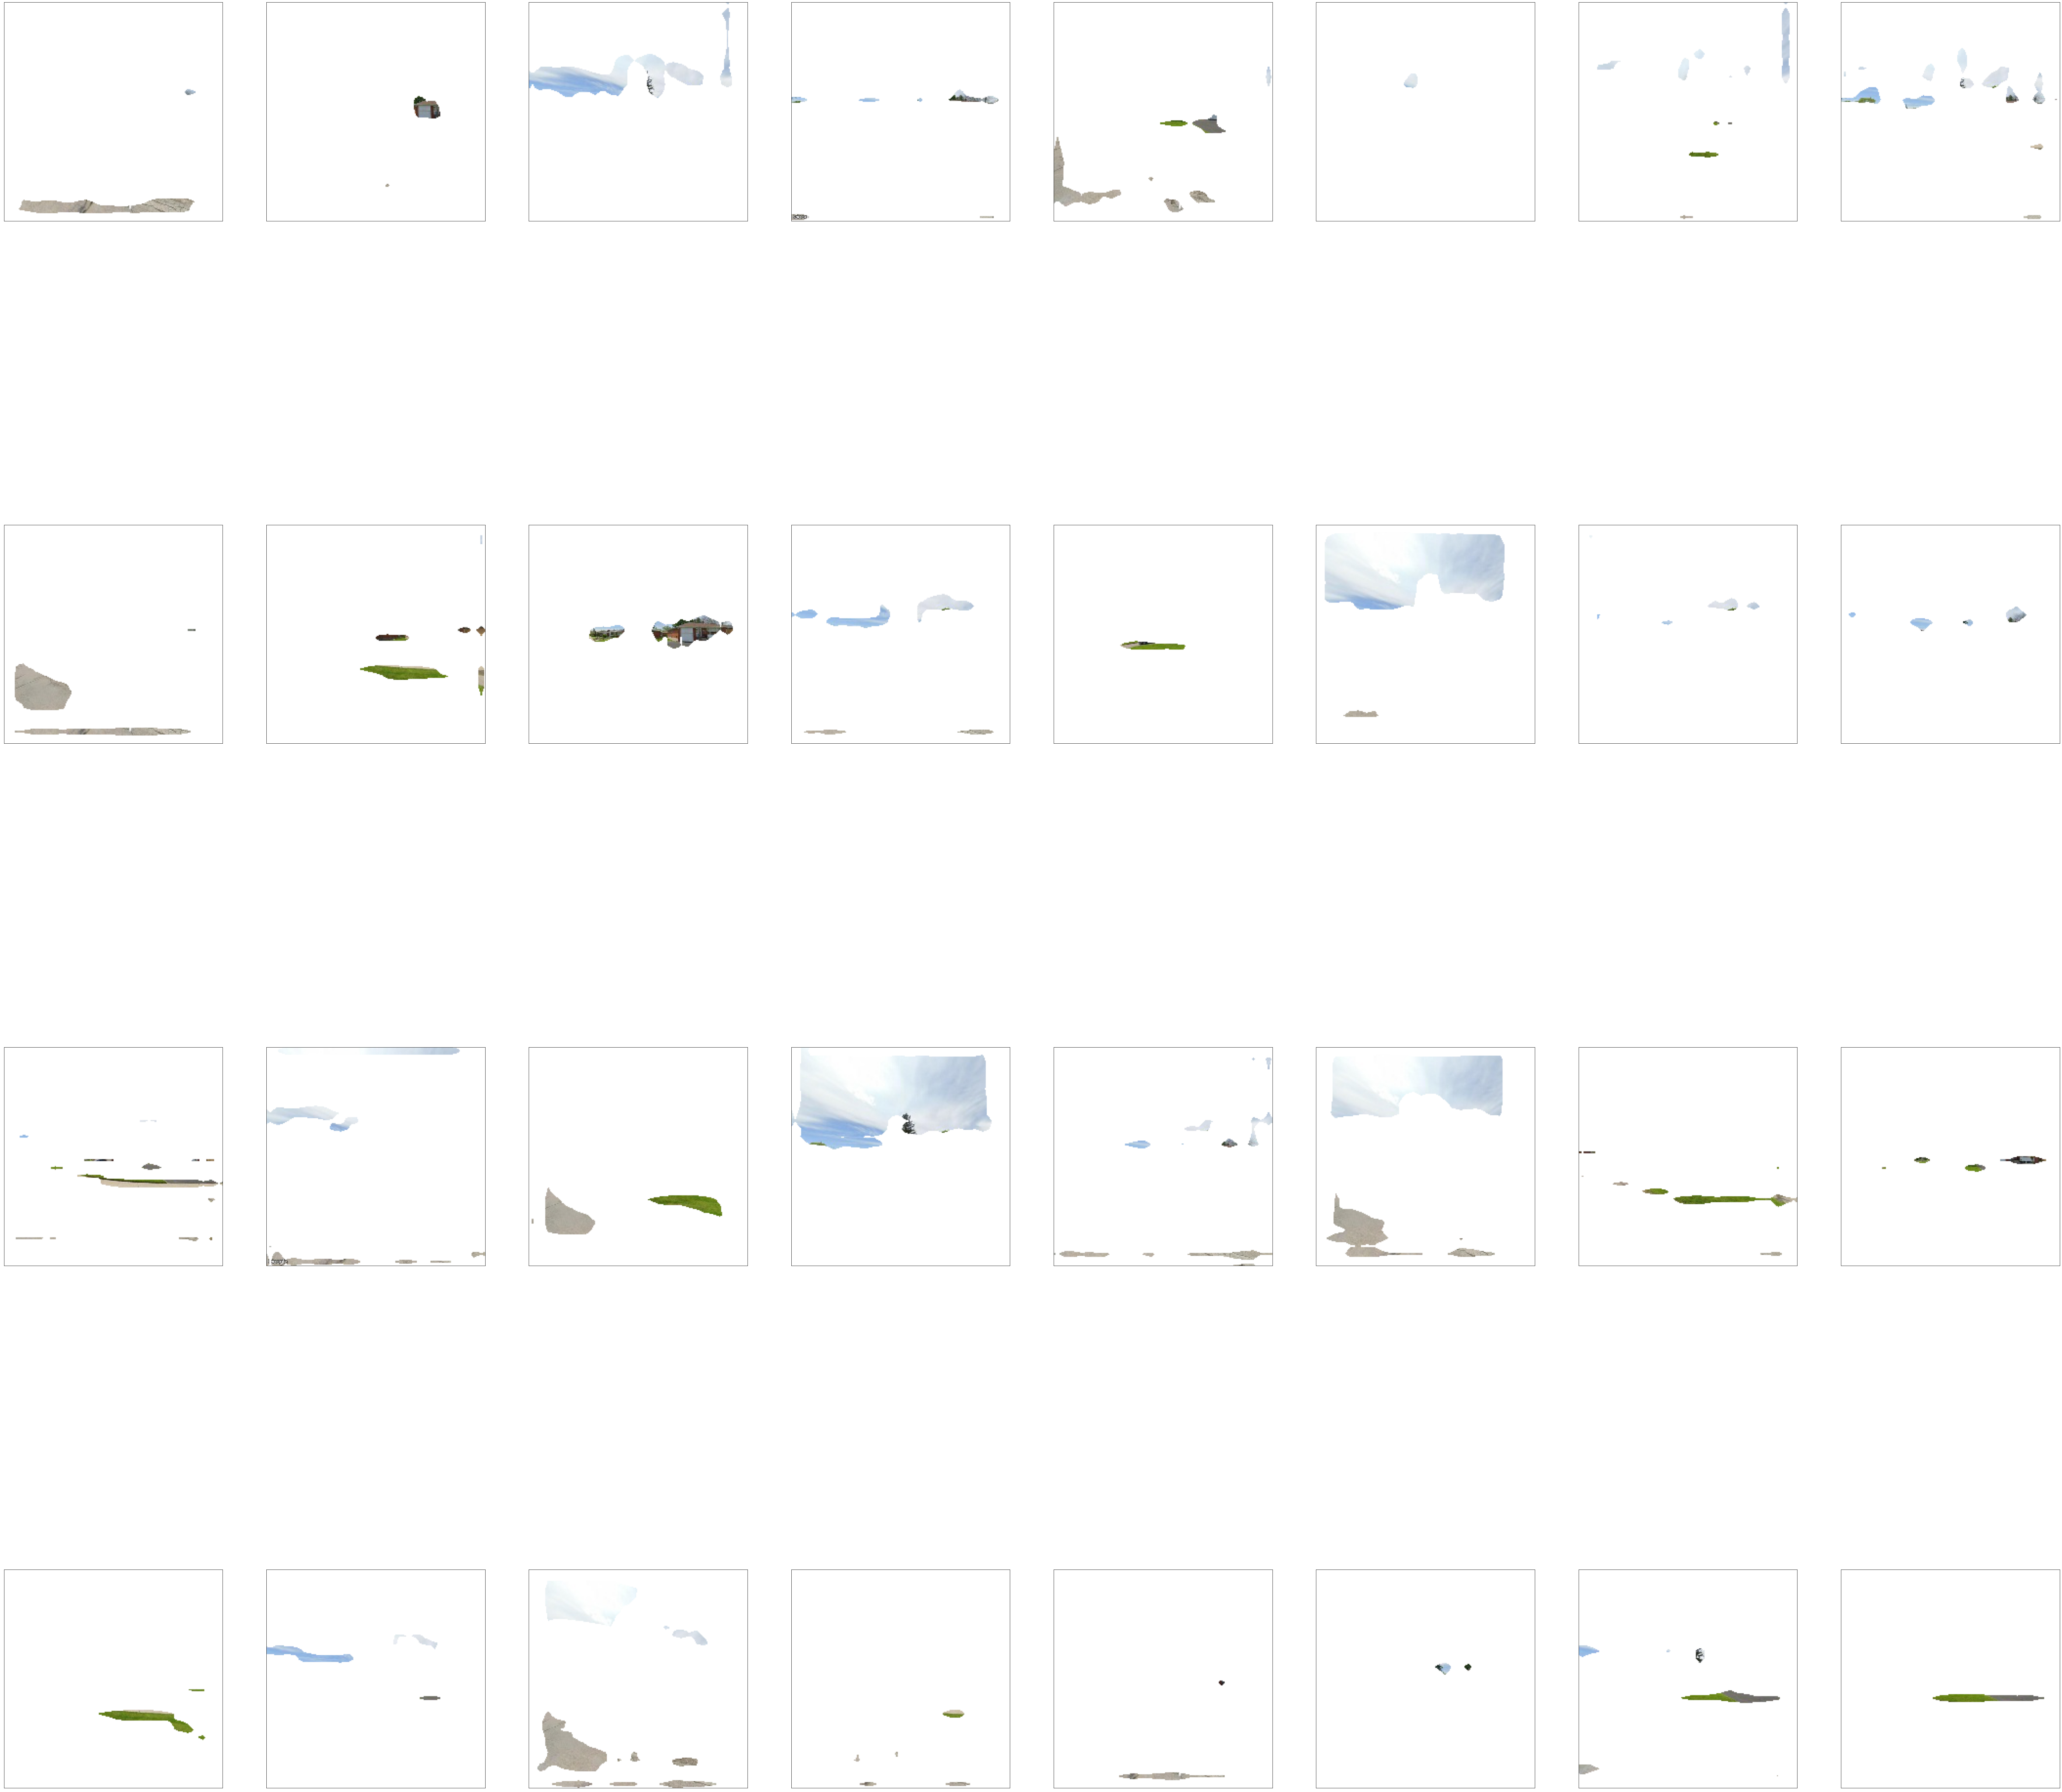

128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


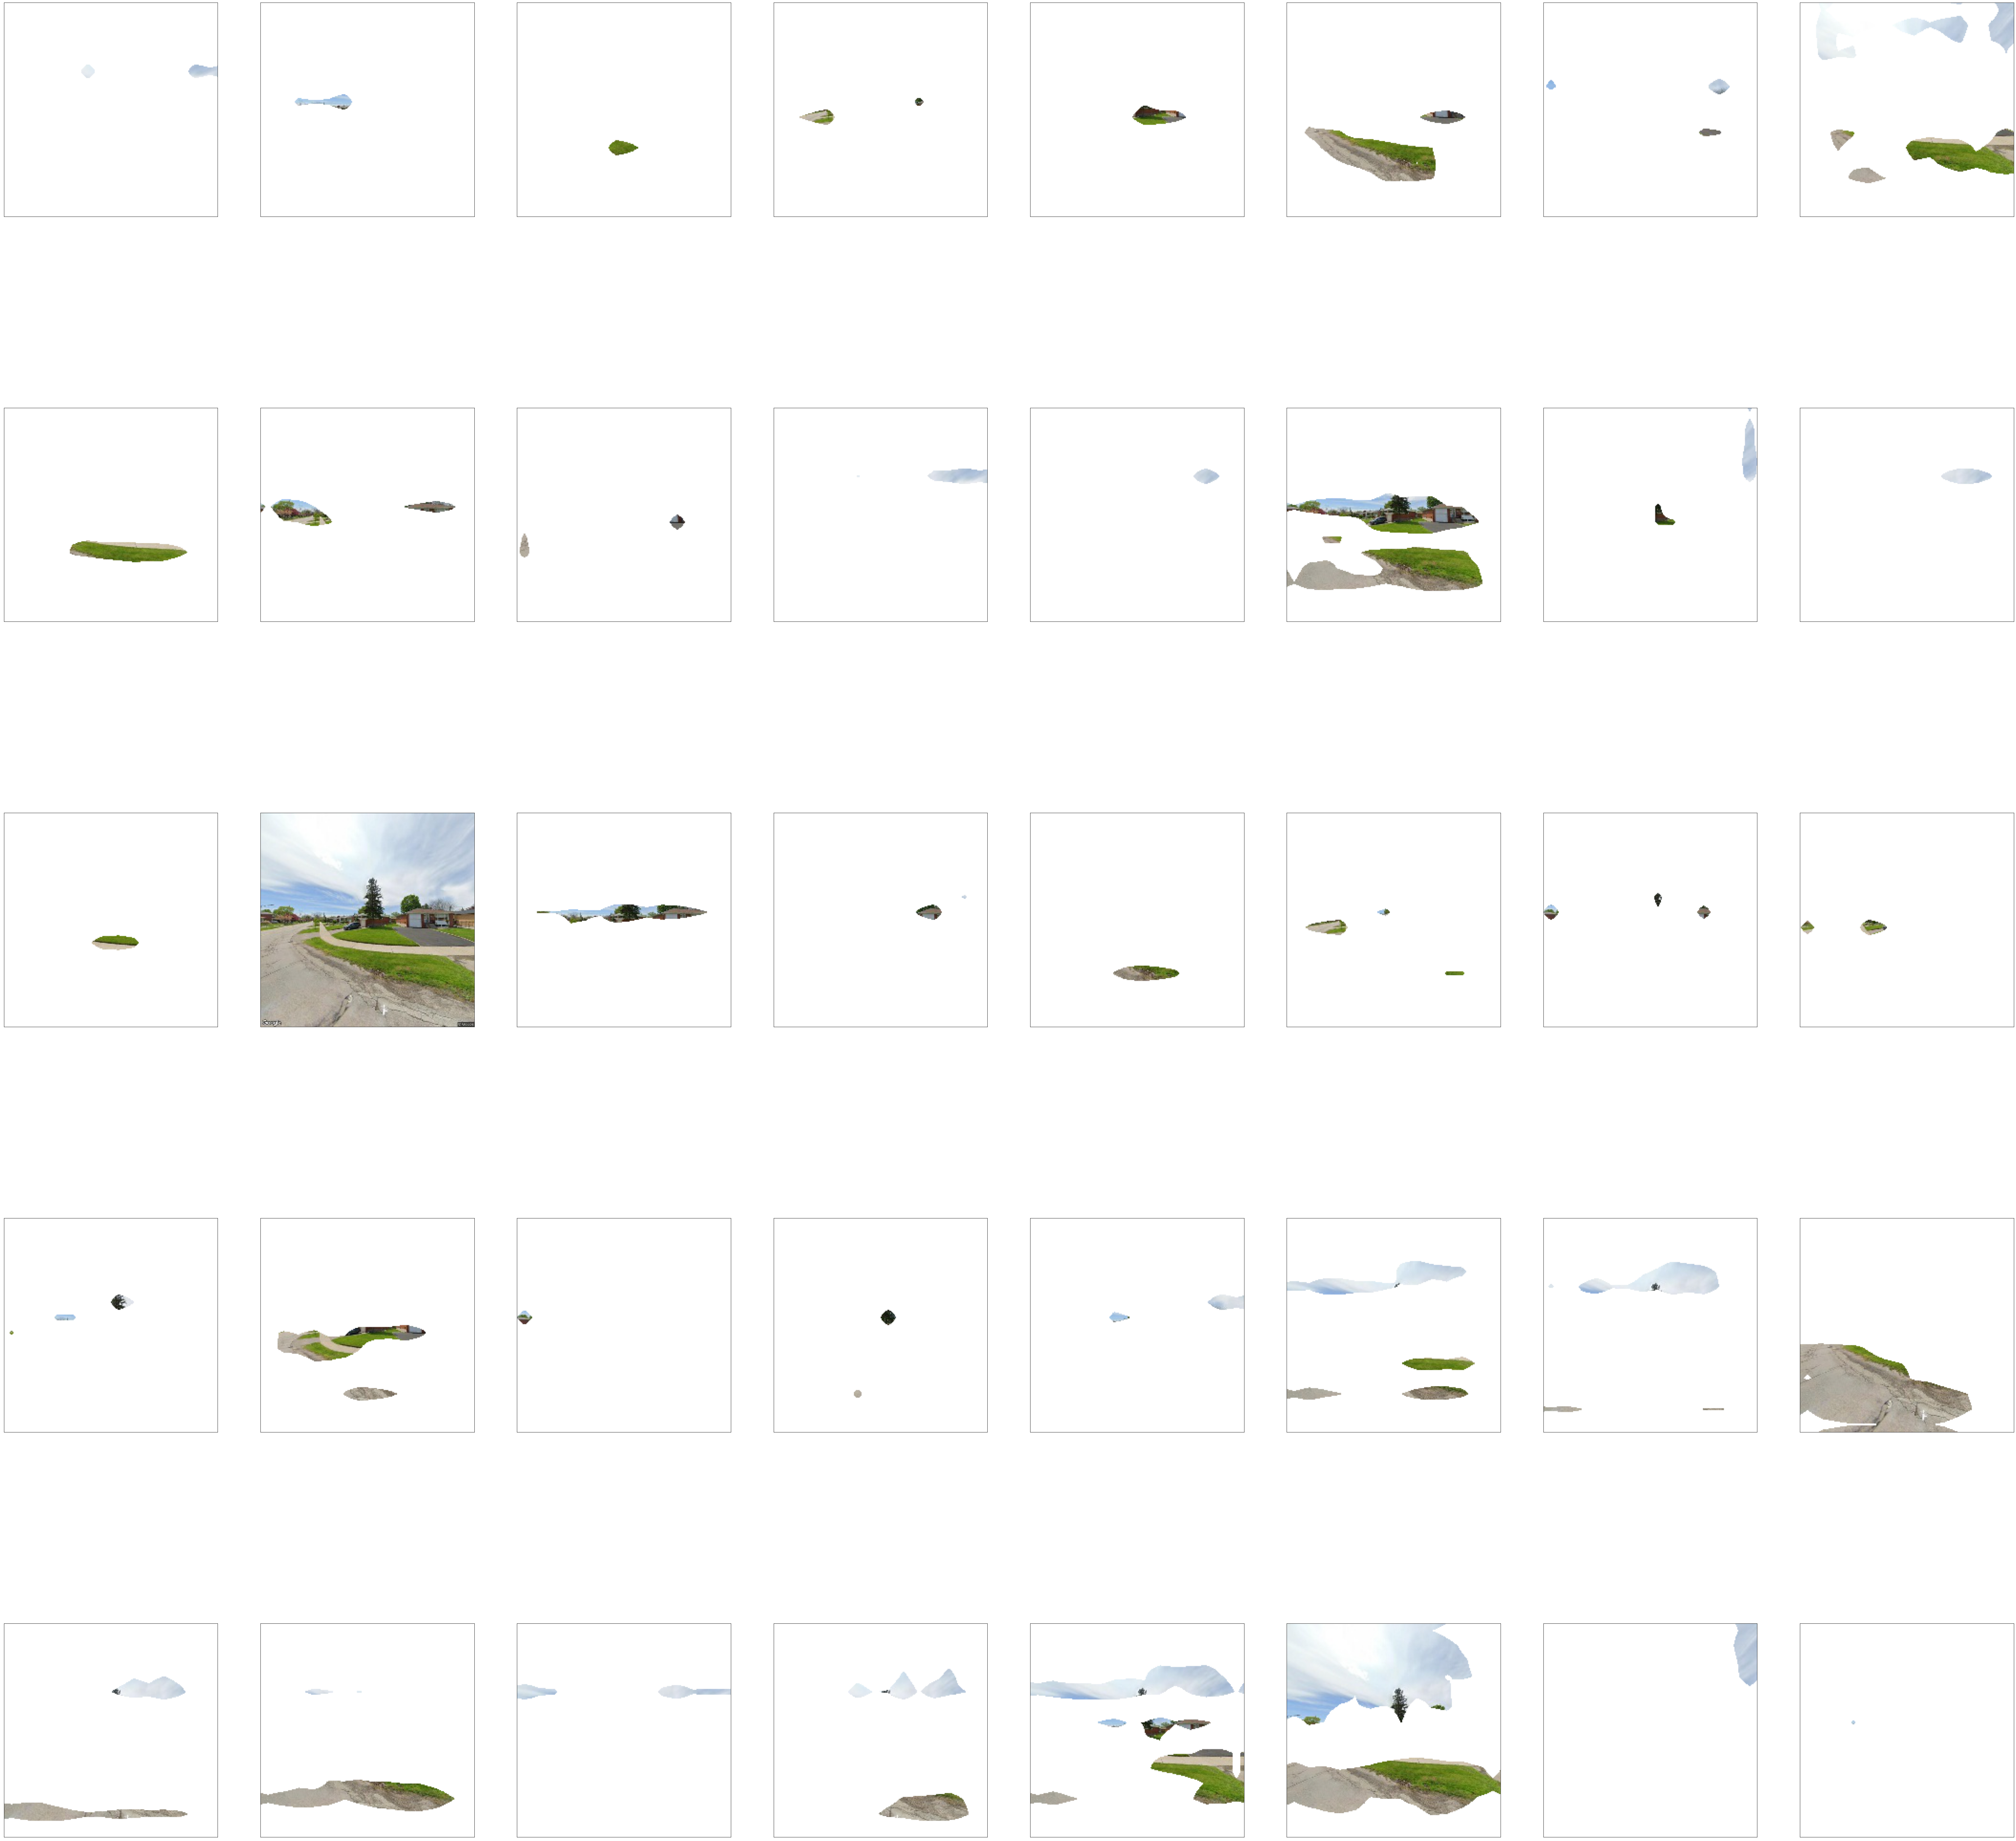

In [16]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
from skimage.transform import resize
# load the image with the required shape
# img = load_img('image_data_448/6123.jpg', target_size=(448, 448))
# # convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
# img = preprocess_input(img)
# get feature map for first hidden layer
cnns = [1,5,9,13,17]
outputs = [model.layers[i+1].output for i in cnns]
model_layers = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model_layers.predict(img)
square = 8
power = 1
img = img.reshape((224,224,3))
pyplot.figure(figsize=(35,35))
pyplot.imshow(img/255)
for fmap in feature_maps:
    print(fmap.shape[-1])
    # plot all 64 maps in an 8x8 squares
    ix = 1
    pyplot.subplots(power,8,figsize=(100,100))
    for _ in range(8):
        for _ in range(power):
            # specify subplot and turn of axis
            ax = pyplot.subplot(power, 8, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            scale = 224
            mask = resize(fmap[0,:,:,ix-1],(scale,scale))
            if np.max(mask) != 0:
                mask = np.round(mask.reshape(scale,scale,1) / np.max(mask))
                img_small = resize(img,(scale,scale)) / np.max(img)
                pyplot.imshow(np.dstack([img_small,mask]))
            ix += 1
    # show the figure
    power += 1
    pyplot.show()

In [ ]:
fmap[0,:,:,ix-1].shape

In [ ]:
np.max(mask)